<h2> A simple Genetic Algorithm for the approximation of the major axis of an ellipse </h2>

<h4>Massimo Montanaro (collab. Federico Calesella)</h4>

<p>This project is only an exercise in writing a genetic algorithm for the <i>stochastic search</i> of the pair of points with the maximum distance on the perimeter of an ellipse. The line passing through these two points corresponds to the major axis of the ellipse.</p>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def draw_ellipse(center, radius):

    img = np.ones((512,512,3), np.uint8) * 255
    ellipse = cv2.ellipse(img, center, radius, 31, 0, 360, (0,0,0),-1)
    plt.imshow(ellipse)
    
    return ellipse

<p> <i>cv2.ellipse</i> needs 2 tuples (center_x, center_y) and (half_xaxis, half_yaxis), so what we want to approximate is max(half_xaxis, half_yaxis) * 2</p>

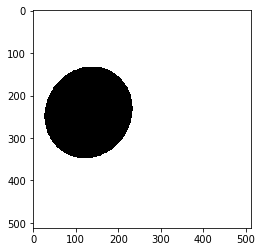

In [3]:
ellipse = draw_ellipse((130,240), (100,110))

<p> <i>extract_expoints</i> is a function that extracts the coordinates of the points of the contour of the ellipse

In [4]:
def extract_expoints(ellipse):
    external_points = []
    
    for count in range(ellipse.shape[0]):
        row = ellipse[count,:,0]
        row_point = np.array(np.where(row == 0))
        if row_point.shape[1] != 0:
            left_point = row_point.min()
            right_point = row_point.max()
            lista = [count, left_point, right_point]
            external_points.append(lista)
            
    external_points = np.array(external_points)
    unique_list = np.zeros((external_points.shape[0]*2,2))
    unique_list[0:external_points.shape[0],0:2] = external_points[0:external_points.shape[0],0:2]
    reversed_half_external_points = np.flip(external_points, 0)
    unique_list[external_points.shape[0]:,0:2] = reversed_half_external_points[0:external_points.shape[0],(0,2)]
    points = np.flip(unique_list, 1)
    
    return points

In [5]:
points = extract_expoints(ellipse)
points[:10,:]

array([[126., 133.],
       [120., 134.],
       [115., 135.],
       [111., 136.],
       [109., 137.],
       [106., 138.],
       [103., 139.],
       [100., 140.],
       [ 97., 141.],
       [ 95., 142.]])

<p>Implementing GA </p>

In [6]:
def population (n, points):

    rand_coord = np.random.randint(0, points.shape[0], size = (n, 2))
        
    return rand_coord

In [7]:
def find_distance (population, points):
    
    distances = []
    
    for count in range(0, population.shape[0]):
        
        difx = points[int(population[count,0]),0] - points[int(population[count,1]),0]
        dify = points[int(population[count,0]),1] - points[int(population[count,1]),1]
        distance = np.sqrt((difx ** 2) + (dify ** 2))
        distances.append(distance)
        
    return np.array(distances)

In [8]:
def find_better_combination (population, distances, n_best):
    
    ordered_population = np.zeros((population.shape[0], population.shape[1]))
    
    for count1, count2 in enumerate(np.flip(distances.argsort())):
        ordered_population[count1,:] = population[count2,:]
    
    best_distance = distances[np.flip(distances.argsort())[0]]
        
    return (best_distance, ordered_population[0:n_best, :])

In [9]:
def next_generation (best_population, n_population, new, mutation_rate, points):
    
    point_from = best_population[:,0].ravel()
    point_to = best_population[:,1].ravel()
    
    rand_point_from = np.random.choice(point_from, new)
    mutate_from = np.random.randint(-(mutation_rate-1), mutation_rate, rand_point_from.shape[0])
    mutated_point_from = rand_point_from + mutate_from
    
    if any(mutated_point_from > (points.shape[0] - 1)):
        out_bound = np.where(mutated_point_from > (points.shape[0] - 1))[0]
        for ind_out in out_bound:
            mutated_point_from[ind_out] = mutated_point_from[ind_out] - points.shape[0]
    
    rand_point_to = np.random.choice(point_to, new)
    mutate_to = np.random.randint(-(mutation_rate-1), mutation_rate, rand_point_to.shape[0])
    mutated_point_to = rand_point_to + mutate_to
    
    if any(mutated_point_to > (points.shape[0] - 1)):
        out_bound = np.where(mutated_point_to > (points.shape[0] - 1))[0]
        for ind_out in out_bound:
            mutated_point_to[ind_out] = mutated_point_to[ind_out] - points.shape[0]
        
    next_gen = np.zeros((n_population, 2))
    next_gen[0:new, 0] = mutated_point_from
    next_gen[0:new, 1] = mutated_point_to

    for count in range(new, next_gen.shape[0]):
        next_gen[count,0] = np.random.randint(0, points.shape[0], 1)
        next_gen[count,1] = np.random.randint(0, points.shape[0], 1)
        
    return next_gen

In [10]:
def genetic_algorithm (pop_size, n_iteration, n_best, new, mutation_rate, points):
    
    maj_axis = 0
    coord = None
    
    pop = population(pop_size, points)
    distances = find_distance(pop, points)
    
    best_distance, best_ind = find_better_combination(pop, distances, n_best)
    
    maj_axis = best_distance
    coord = best_ind[0, :]
    
    for count in range(0, n_iteration): 
        pop = next_generation(best_ind, pop_size, new, mutation_rate, points)
        distances = find_distance(pop, points)
        
        best_distance, best_ind = find_better_combination(pop, distances, n_best)
        
        if best_distance > maj_axis:
            maj_axis = best_distance
            coord = best_ind[0,:]
    
    return ([points[int(coord[0])], points[int(coord[1])]], maj_axis)

In [11]:
coord, maj_axis = genetic_algorithm(50, 100, 10, 25, 60, points)

In [12]:
coord, int(maj_axis)

([array([194., 150.]), array([ 68., 331.])], 220)

<p> How we can see int(maj_axis) is equal to 110 * 2 </p>

In [13]:
def draw_maj_axis(ellipse, coord):
    
    pt1 = (int(coord[0][0]), int(coord[0][1]))
    pt2 = (int(coord[1][0]), int(coord[1][1]))
    line = cv2.line(ellipse, pt1 = pt1, pt2 = pt2, color=(0,255,0), thickness=1)
    
    plt.imshow(line)

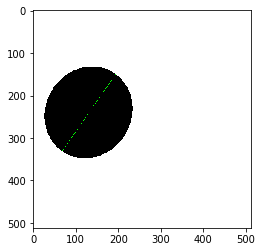

In [14]:
draw_maj_axis(ellipse, coord)

<p> Let's try other ellipses </p>

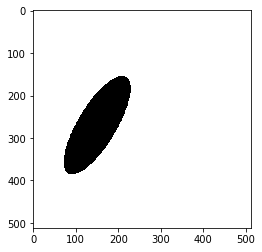

In [15]:
ellipse = draw_ellipse((150,270), (45,132))

263


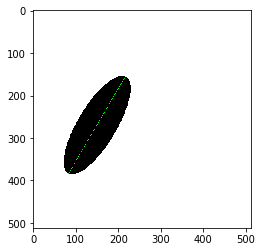

In [16]:
points = extract_expoints(ellipse)
coord, maj_axis = genetic_algorithm(50, 100, 10, 25, 60, points)
print(int(maj_axis))
draw_maj_axis(ellipse, coord)

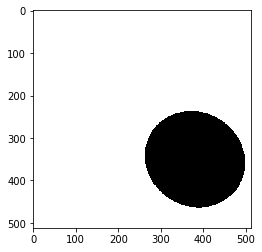

In [17]:
ellipse = draw_ellipse((380,350), (120,110))

240


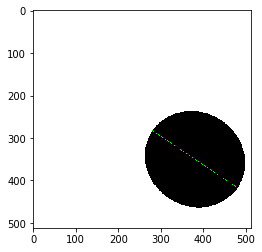

In [18]:
points = extract_expoints(ellipse)
coord, maj_axis = genetic_algorithm(50, 100, 10, 25, 60, points)
print(int(maj_axis))
draw_maj_axis(ellipse, coord)